In [2]:
# Importar Bibliotecas de Ciencia de Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Bibliotecas de Tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# Bibliotecas del sistema
from pathlib import Path
import os.path
import random

# Bibliotecas de Visualización
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Métricas
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [3]:
!git clone https://github.com/happodaikarin/bird-groups

fatal: destination path 'bird-groups' already exists and is not an empty directory.


In [4]:
TAMANO_LOTE = 32
TAMANO_OBJETIVO = (224, 224)

In [5]:
# Recorrer cada directorio
conjunto_datos = "bird-groups/train/"
directorio_imagenes = Path(conjunto_datos)

# Obtener rutas de archivos y etiquetas
rutas_archivos = list(directorio_imagenes.glob(r'**/*.JPG')) + list(directorio_imagenes.glob(r'**/*.jpg')) + list(directorio_imagenes.glob(r'**/*.png')) + list(directorio_imagenes.glob(r'**/*.png'))

etiquetas = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], rutas_archivos))

rutas_archivos = pd.Series(rutas_archivos, name='RutaArchivo').astype(str)
etiquetas = pd.Series(etiquetas, name='Etiqueta')

# Concatenar rutas de archivos y etiquetas
dataframe_imagenes = pd.concat([rutas_archivos, etiquetas], axis=1)


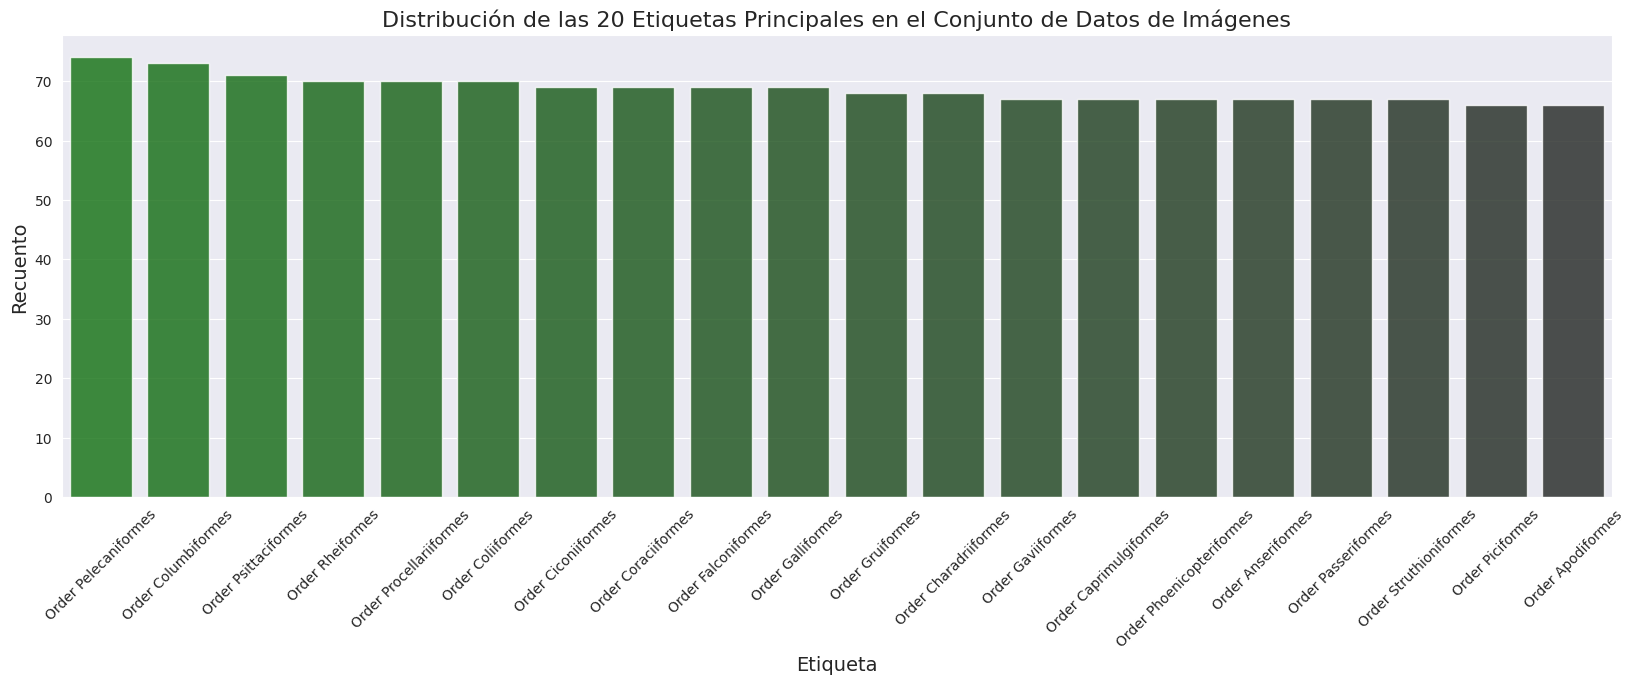

In [6]:
# Obtener las 20 etiquetas principales
conteo_etiquetas = dataframe_imagenes['Etiqueta'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, alpha=0.8, palette='dark:green_r')
plt.title('Distribución de las 20 Etiquetas Principales en el Conjunto de Datos de Imágenes', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Recuento', fontsize=14)
plt.xticks(rotation=45)
plt.show()

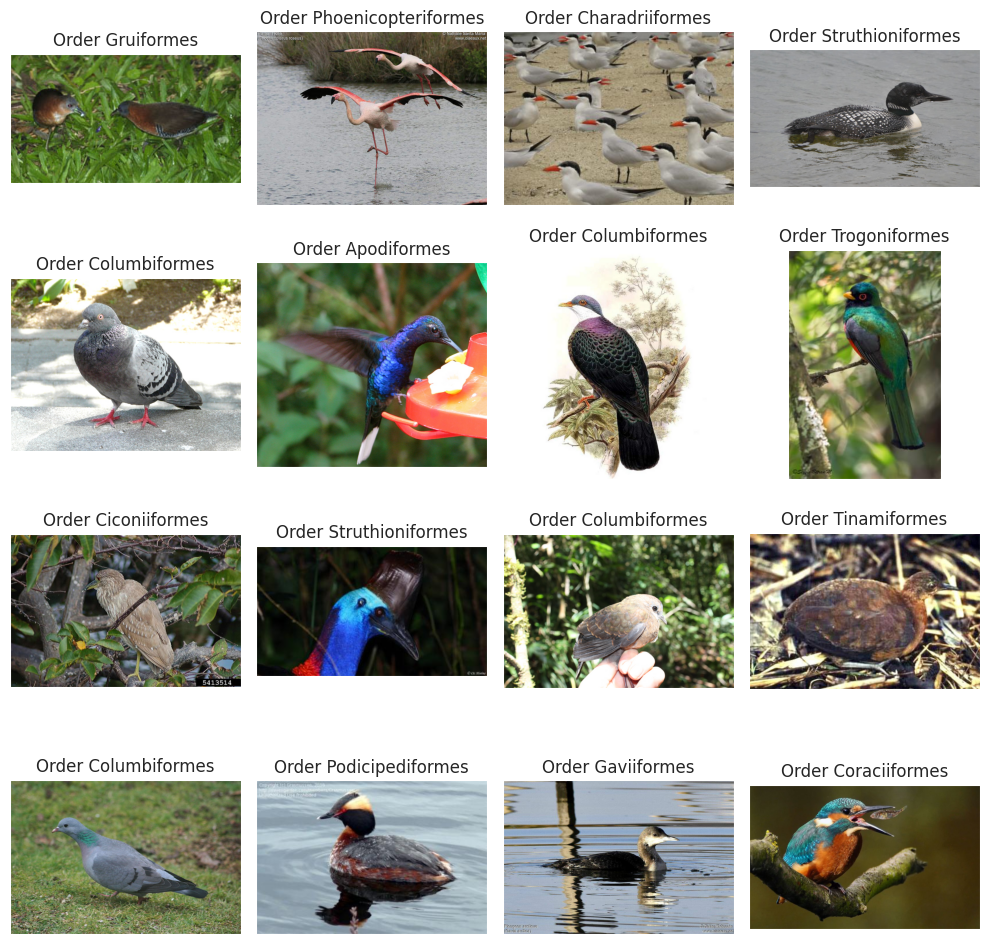

In [7]:
# Mostrar 16 imágenes del conjunto de datos con sus etiquetas
indices_aleatorios = np.random.randint(0, len(dataframe_imagenes), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataframe_imagenes.RutaArchivo[indices_aleatorios[i]]))
    ax.set_title(dataframe_imagenes.Etiqueta[indices_aleatorios[i]])
plt.tight_layout()
plt.show()


In [8]:
def calcular_ela_cv(ruta, calidad):
    nombre_temporal = 'nombre_temporal.jpeg'
    ESCALA = 15
    img_original = cv2.imread(ruta)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    cv2.imwrite(nombre_temporal, img_original, [cv2.IMWRITE_JPEG_QUALITY, calidad])

    # Leer la imagen comprimida
    img_comprimida = cv2.imread(nombre_temporal)

    # Obtener la diferencia absoluta entre img_original e img_comprimida y multiplicar por la escala
    diferencia = ESCALA * cv2.absdiff(img_original, img_comprimida)
    return diferencia


def convertir_a_imagen_ela(ruta, calidad):
    nombre_temporal = 'nombre_temporal.jpeg'
    nombre_ela = 'temp_ela.png'
    imagen = Image.open(ruta).convert('RGB')
    imagen.save(nombre_temporal, 'JPEG', calidad=calidad)
    imagen_temporal = Image.open(nombre_temporal)

    imagen_ela = ImageChops.difference(imagen, imagen_temporal)

    extrema = imagen_ela.getextrema()
    max_diferencia = max([ex[1] for ex in extrema])
    if max_diferencia == 0:
        max_diferencia = 1

    escala = 255.0 / max_diferencia
    imagen_ela = ImageEnhance.Brightness(imagen_ela).enhance(escala)

    return imagen_ela


def muestra_aleatoria(ruta, extension=None):
    if extension:
        elementos = Path(ruta).glob(f'*.{extension}')
    else:
        elementos = Path(ruta).glob(f'*')

    elementos = list(elementos)

    seleccion = random.choice(elementos)
    return seleccion.as_posix()


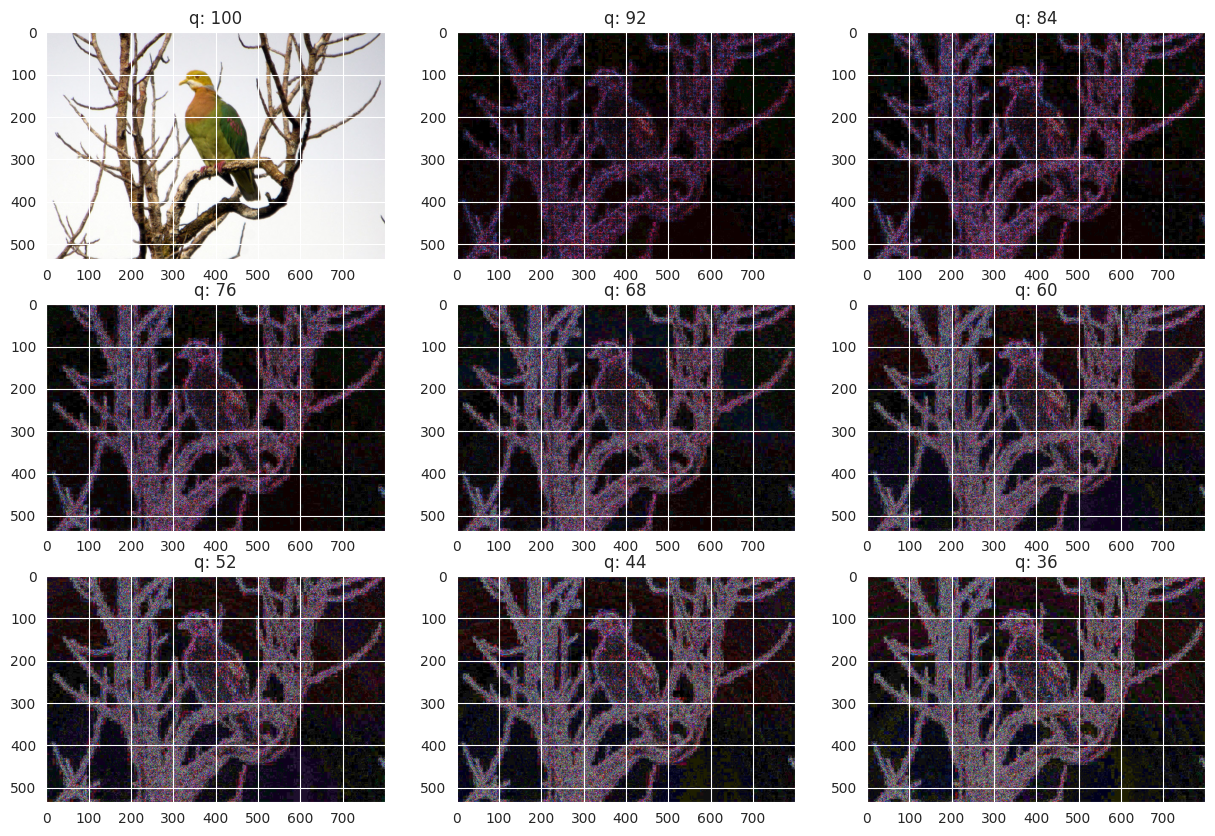

In [9]:
# Ver una muestra aleatoria del conjunto de datos
p = muestra_aleatoria('/content/bird-groups/train/Order Columbiformes/')
imagen_original = cv2.imread(p)
imagen_original = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB) / 255.0
valor_inicial = 100
columnas = 3
filas = 3

fig = plt.figure(figsize=(15, 10))
for i in range(1, columnas * filas + 1):
    calidad = valor_inicial - (i-1) * 8
    img = calcular_ela_cv(ruta=p, calidad=calidad)
    if i == 1:
        img = imagen_original.copy()
    ax = fig.add_subplot(filas, columnas, i)
    ax.title.set_text(f'q: {calidad}')
    plt.imshow(img)
plt.show()


In [10]:
# Separar en datos de entrenamiento y prueba
train_df, test_df = train_test_split(dataframe_imagenes, test_size=0.2, shuffle=True, random_state=42)

# Aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2],  # Variaciones en el brillo
    channel_shift_range=150.0,   # Variaciones en la saturación
    validation_split=0.2  # Mantenemos una división para validación
)

# Generador para el conjunto de entrenamiento
imagenes_entrenamiento = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='RutaArchivo',
    y_col='Etiqueta',
    target_size=TAMANO_OBJETIVO,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=TAMANO_LOTE,
    shuffle=True,
    seed=42,
    subset='training'
)

# Generador para el conjunto de validación
imagenes_validacion = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='RutaArchivo',
    y_col='Etiqueta',
    target_size=TAMANO_OBJETIVO,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=TAMANO_LOTE,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 1244 validated image filenames belonging to 29 classes.
Found 311 validated image filenames belonging to 29 classes.


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime

# Paso de Aumento de Datos
aumento_datos = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [12]:
# Cargar el modelo preentrenado
modelo_preentrenado = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

In [13]:
inputs = modelo_preentrenado.input
x = aumento_datos(inputs)

x = Dense(128, activation='relu')(modelo_preentrenado.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

outputs = Dense(29, activation='softmax')(x)  # Asegúrate de ajustar esta capa según el número de clases

modelo = Model(inputs=inputs, outputs=outputs)

modelo.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint(
    filepath='modelo_punto_de_control.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

registro_directorio = "registros/entrenamiento/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=registro_directorio, histogram_freq=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.00001
)

# Entrenamiento del modelo sin EarlyStopping
historia = modelo.fit(
    imagenes_entrenamiento,
    steps_per_epoch=len(imagenes_entrenamiento),
    validation_data=imagenes_validacion,
    validation_steps=len(imagenes_validacion),
    epochs=50,  # Número total de épocas que deseas
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        reduce_lr
    ]
)


Epoch 1/50
 4/39 [==>...........................] - ETA: 12s - loss: 11.1158 - accuracy: 0.0547

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


39/39 [==============================] - ETA: 0s - loss: 6.5460 - accuracy: 0.0378
Epoch 1: val_loss improved from inf to 3.52688, saving model to modelo_punto_de_control.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 82s 1s/step - loss: 6.5460 - accuracy: 0.0378 - val_loss: 3.5269 - val_accuracy: 0.0450 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 3.6077 - accuracy: 0.0378
Epoch 2: val_loss improved from 3.52688 to 3.36657, saving model to modelo_punto_de_control.h5
39/39 [==============================] - 38s 965ms/step - loss: 3.6077 - accuracy: 0.0378 - val_loss: 3.3666 - val_accuracy: 0.0514 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 3.4467 - accuracy: 0.0378
Epoch 3: val_loss did not improve from 3.36657
39/39 [==============================] - 40s 1s/step - loss: 3.4467 - accuracy: 0.0378 - val_loss: 3.3981 - val_accuracy: 0.0418 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 3.3900 - accuracy: 0.0442
Epoch 4: val_loss did not improve from 3.36657
39/39 [==============================] - 37s 953ms/step - loss: 3.3900 - accuracy: 0.044

In [16]:
resultados = modelo.evaluate(imagenes_entrenamiento, verbose=0)

print("    Pérdida en la Prueba: {:.5f}".format(resultados[0]))
print("Exactitud en la Prueba: {:.2f}%".format(resultados[1] * 100))

    Pérdida en la Prueba: 1.79743
Exactitud en la Prueba: 52.89%


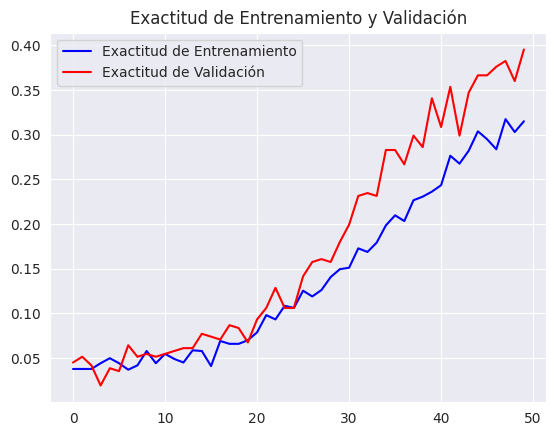

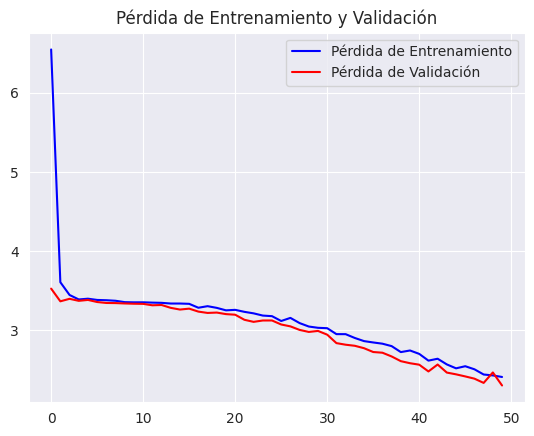

In [17]:
# Obtener las métricas de entrenamiento y validación del historial
exactitud_entrenamiento = historia.history['accuracy']
exactitud_validacion = historia.history['val_accuracy']

pérdida_entrenamiento = historia.history['loss']
pérdida_validacion = historia.history['val_loss']

# Crear una secuencia de épocas
épocas = range(len(exactitud_entrenamiento))

# Graficar la evolución de la exactitud durante el entrenamiento y la validación
plt.plot(épocas, exactitud_entrenamiento, 'b', label='Exactitud de Entrenamiento')
plt.plot(épocas, exactitud_validacion, 'r', label='Exactitud de Validación')

plt.title('Exactitud de Entrenamiento y Validación')
plt.legend()
plt.figure()

# Graficar la evolución de la pérdida durante el entrenamiento y la validación
plt.plot(épocas, pérdida_entrenamiento, 'b', label='Pérdida de Entrenamiento')
plt.plot(épocas, pérdida_validacion, 'r', label='Pérdida de Validación')

plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.show()


In [19]:
# Predecir la etiqueta de las test_images
predicciones = modelo.predict(imagenes_entrenamiento)
predicciones = np.argmax(predicciones, axis=1)

# Mapear las etiquetas
etiquetas = (imagenes_entrenamiento.class_indices)
etiquetas = dict((v, k) for k, v in etiquetas.items())
predicciones = [etiquetas[k] for k in predicciones]

# Mostrar el resultado
print(f'Las primeras 5 predicciones: {predicciones[:5]}')


39/39 [==============================] - 29s 674ms/step
Las primeras 5 predicciones: ['Order Coraciiformes', 'Order Rheiformes', 'Order Apodiformes', 'Order Gaviiformes', 'Order Psittaciformes']


NameError: ignored

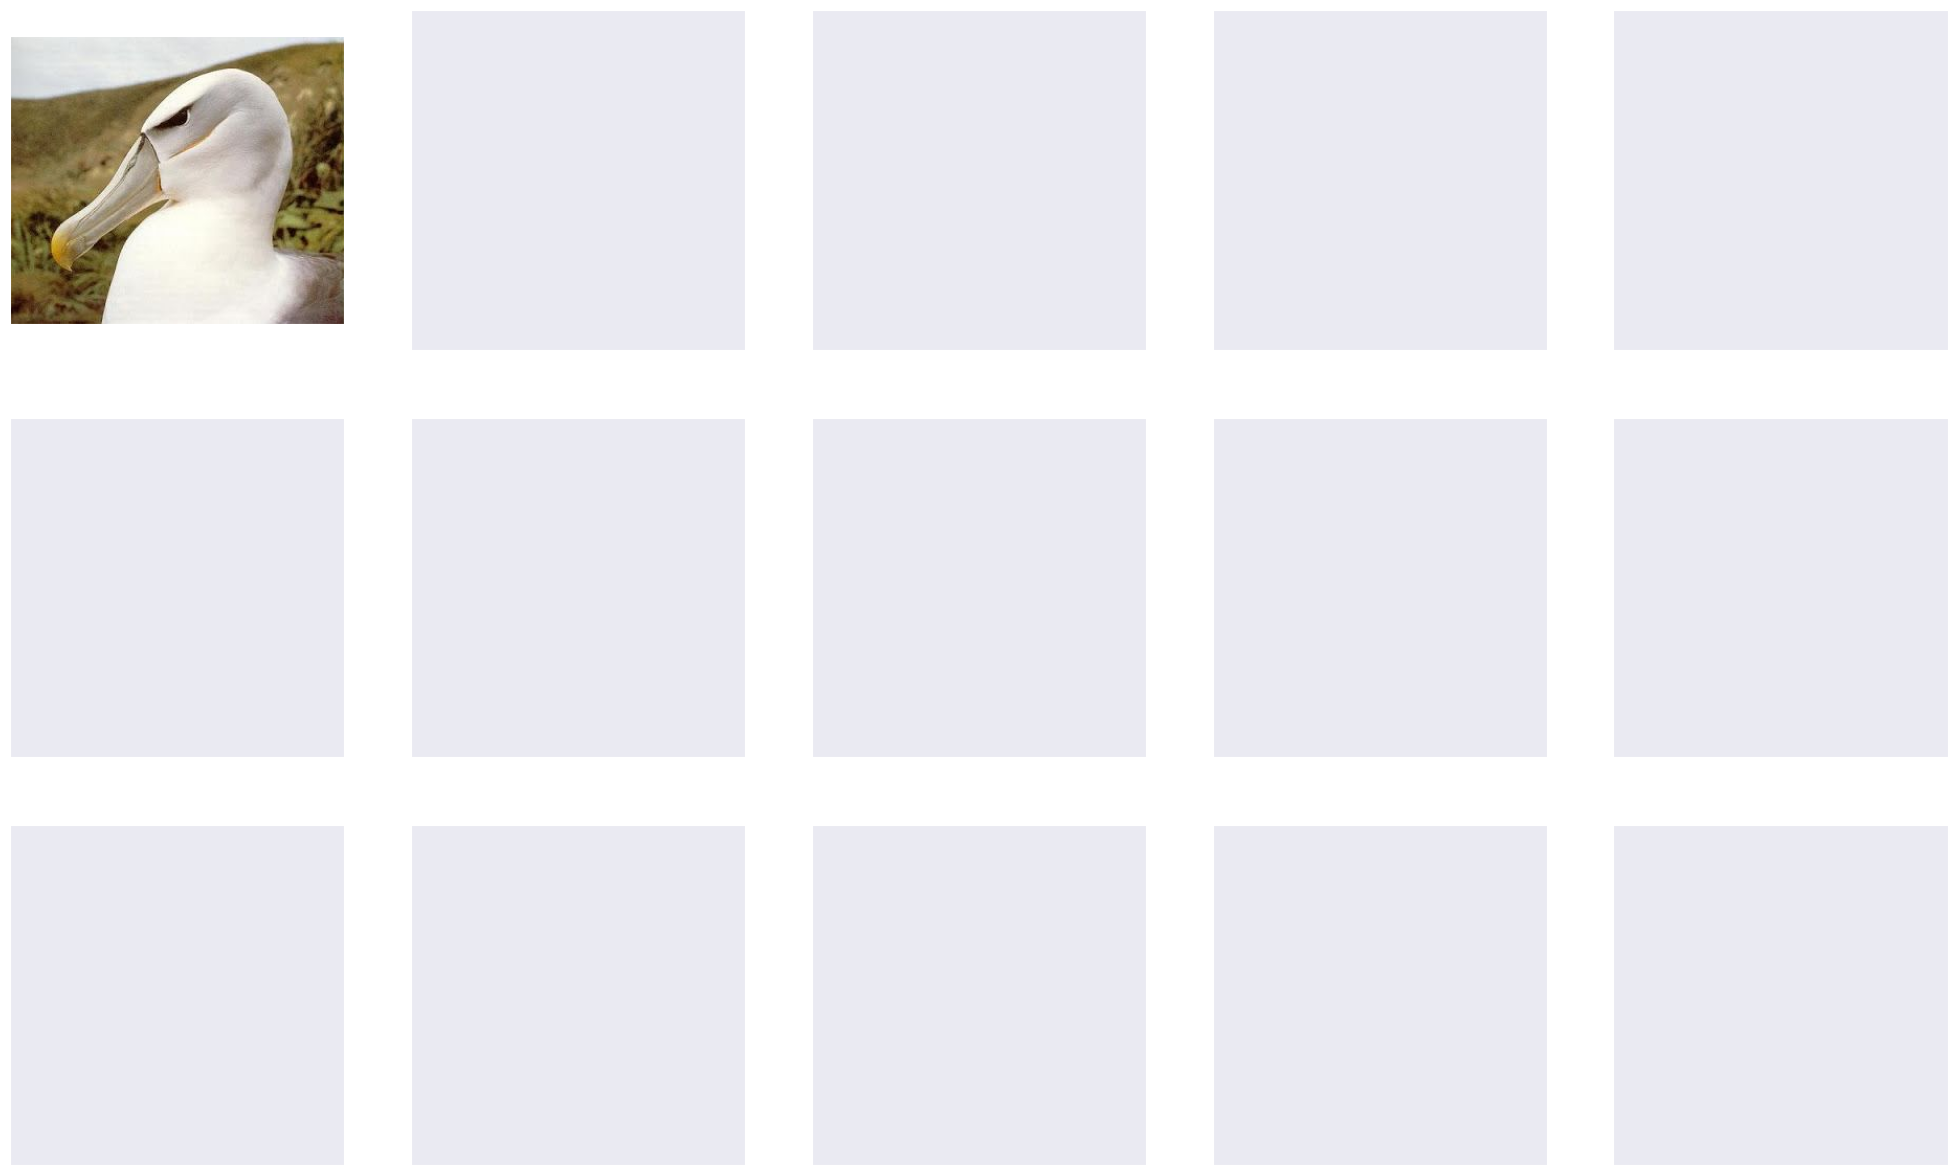

In [22]:
# Mostrar 25 imágenes aleatorias del conjunto de datos con sus etiquetas
indices_aleatorios = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.RutaArchivo.iloc[indices_aleatorios[i]]))
    if test_df.Etiqueta.iloc[indices_aleatorios[i]] == pred[indices_aleatorios[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"Verdadero: {test_df.Etiqueta.iloc[indices_aleatorios[i]]}\nPredicción: {pred[indices_aleatorios[i]]}", color=color)
plt.show()
plt.tight_layout()


In [23]:
y_test = list(test_df.Etiqueta)
print(classification_report(y_test, pred))

NameError: ignored

In [24]:
def obtener_matriz_de_imagen(img_path, tamaño):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=tamaño)
    matriz = tf.keras.preprocessing.image.img_to_array(img)
    matriz = np.expand_dims(matriz, axis=0)
    return matriz

def generar_mapa_de_calor_gradcam(matriz_imagen, modelo, nombre_ultima_capa_conv, indice_pred=None):
    modelo_grad = tf.keras.models.Model(
        [modelo.inputs], [modelo.get_layer(nombre_ultima_capa_conv).output, modelo.output]
    )
    with tf.GradientTape() as cinta:
        salida_ultima_capa_conv, predicciones = modelo_grad(matriz_imagen)
        if indice_pred is None:
            indice_pred = tf.argmax(predicciones[0])
        canal_clase = predicciones[:, indice_pred]

    gradientes = cinta.gradient(canal_clase, salida_ultima_capa_conv)
    gradientes_promedio = tf.reduce_mean(gradientes, axis=(0, 1, 2))
    salida_ultima_capa_conv = salida_ultima_capa_conv[0]
    mapa_de_calor = salida_ultima_capa_conv @ gradientes_promedio[..., tf.newaxis]
    mapa_de_calor = tf.squeeze(mapa_de_calor)

    # Para fines de visualización, normalizamos el mapa de calor entre 0 y 1
    mapa_de_calor = tf.maximum(mapa_de_calor, 0) / tf.math.reduce_max(mapa_de_calor)
    return mapa_de_calor.numpy()

def guardar_y_mostrar_gradcam(img_path, mapa_de_calor, ruta_cam="cam.jpg", alpha=0.4):
    # Cargar la imagen original
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Reescalar el mapa de calor a un rango de 0-255
    mapa_de_calor = np.uint8(255 * mapa_de_calor)

    # Utilizar el mapa de colores "jet" para colorear el mapa de calor
    jet = cm.get_cmap("jet")

    # Utilizar los valores RGB del mapa de colores
    colores_jet = jet(np.arange(256))[:, :3]
    mapa_de_calor_jet = colores_jet[mapa_de_calor]

    # Crear una imagen con el mapa de calor coloreado en RGB
    mapa_de_calor_jet = tf.keras.preprocessing.image.array_to_img(mapa_de_calor_jet)
    mapa_de_calor_jet = mapa_de_calor_jet.resize((img.shape[1], img.shape[0]))
    mapa_de_calor_jet = tf.keras.preprocessing.image.img_to_array(mapa_de_calor_jet)

    # Superponer el mapa de calor en la imagen original
    imagen_superpuesta = mapa_de_calor_jet * alpha + img
    imagen_superpuesta = tf.keras.preprocessing.image.array_to_img(imagen_superpuesta)
    # Guardar la imagen superpuesta
    imagen_superpuesta.save(ruta_cam)

    # Mostrar Grad CAM
    # display(Image(ruta_cam))

    return ruta_cam

preprocesar_input = tf.keras.applications.mobilenet_v2.preprocess_input
decodificar_predicciones = tf.keras.applications.mobilenet_v2.decode_predictions

nombre_ultima_capa_conv = "top_conv"
tamaño_imagen = (224, 224, 3)

# Eliminar la softmax de la última capa
modelo.layers[-1].activation = None


NameError: ignored

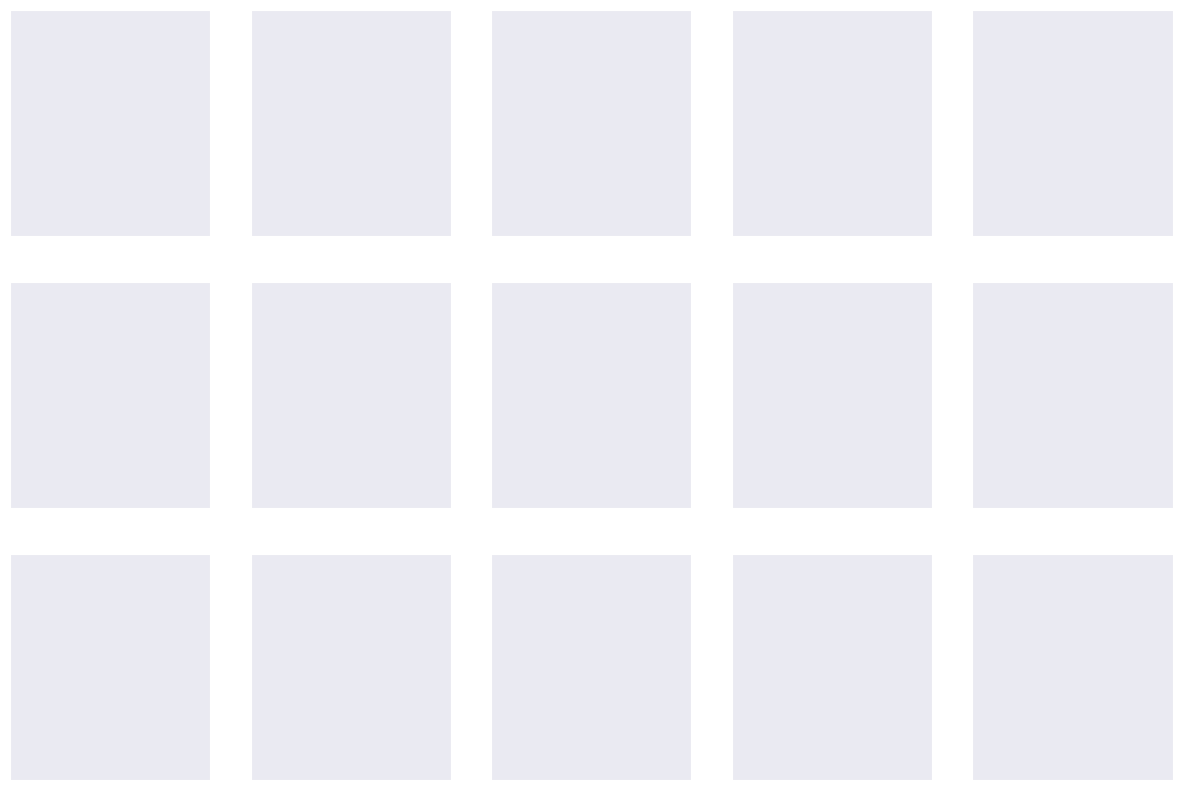

In [25]:
# Mostrar la parte de las imágenes utilizadas por la red neuronal para clasificarlas
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ruta_imagen = test_df.RutaArchivo.iloc[indices_aleatorios[i]]
    matriz_imagen = preprocesar_input(obtener_matriz_de_imagen(ruta_imagen, tamaño=img_size))
    mapa_de_calor = generar_mapa_de_calor_gradcam(matriz_imagen, modelo, nombre_ultima_capa_conv)
    ruta_cam = guardar_y_mostrar_gradcam(ruta_imagen, mapa_de_calor)
    ax.imshow(plt.imread(ruta_cam))
    ax.set_title(f"Verdadero: {test_df.Etiqueta.iloc[indices_aleatorios[i]]}\nPredicción: {pred[indices_aleatorios[i]]}")
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Función para cargar y preprocesar la imagen
def cargar_y_preprocesar_imagen(ruta_imagen, tamaño_objetivo):
    img = image.load_img(ruta_imagen, target_size=tamaño_objetivo)
    matriz_imagen = image.img_to_array(img)
    matriz_imagen_expandida = np.expand_dims(matriz_imagen, axis=0)
    return preprocess_input(matriz_imagen_expandida)

# Función para predecir la clase de una nueva imagen
def predecir_imagen(modelo, imagen_preprocesada):
    prediccion = modelo.predict(imagen_preprocesada)
    clase_predicha = np.argmax(prediccion, axis=1)
    return clase_predicha

# Cargar y preprocesar una imagen nueva
ruta_nueva_imagen = '/contenido/xcz.jpeg'  # Reemplaza con la ruta a tu nueva imagen
imagen_preprocesada = cargar_y_preprocesar_imagen(ruta_nueva_imagen, TARGET_SIZE)

# Predecir la imagen
clase_predicha = predecir_imagen(modelo, imagen_preprocesada)

# Obtener la etiqueta correspondiente
etiquetas = (imagenes_entrenamiento.class_indices)
etiquetas = dict((v, k) for k, v in etiquetas.items())
etiqueta_predicha = etiquetas[clase_predicha[0]]
print(f"La imagen fue clasificada como: {etiqueta_predicha}")


In [ ]:
# Guardar el modelo en el formato SavedModel (recomendado)
modelo.save('modeloV1')

# Cargar el modelo
modelo_cargado = tf.keras.models.load_model('modeloV1')

In [ ]:
from google.colab import files

# Comprimir el directorio del modelo en un archivo ZIP
!zip -r modeloV1.zip modeloV1/

# Descargar el archivo ZIP
files.download('modeloV1.zip')
